# Binary Boosted Trees

### Importamos las librerias necesarias y definimos las variables globales

In [ ]:
# Importado de librerias
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

from imblearn.under_sampling import RandomUnderSampler

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Definición de variables globales
seed = 0

### Cargamos los datos y los transformamos a etiqueta binaria

In [ ]:
# Definición de las funciones necesarias de este apartado

def secuestro(x):

    if x== 'white':
        valor = 0
    else:
        valor = 1

    return valor

In [ ]:
# Cargamos la base de datos de entrenamiento
url = 'https://datos.uemc.es/owncloud/s/tekZoz67bNuD3X4/download?path=%2F&files=DATASET14.csv'
df = pd.read_csv(url, sep=',')

# Cargamos la base de datos de prueba
url_test = 'https://datos.uemc.es/owncloud/s/tekZoz67bNuD3X4/download?path=%2F&files=VALIDATION_WITHOUT_LABELS.csv'
df_test = pd.read_csv(url_test, sep=',')

# Creamos una columna de etiqueta binaria en los datos de entrenamiento
df['clase']=df['label'].apply(secuestro)

# Eliminamos las columnas label y las que no son validas segun el EDA (address, length y weight)
df = df.drop(['address', 'label', 'length','weight'], axis=1)
df_test = df_test.drop(['address', 'length','weight'], axis=1)

# Comprobamos que la carga de datos se ha llevado a cabo correctamente
print('Dataset de entrenamiento:\n', df.head())
print('Dataset sobre el que predecir:\n', df_test.head())

# Nombre y tipo de las columnas del entrenamiento
print('Columnas del dataset:\n{}\n'.format(df.dtypes))

# Cantidad de datos de cada clase
print('Datos de cada clase:\n{}\n'.format(df['clase'].value_counts()))

Dataset de entrenamiento:
    year  day  count  looped  neighbors     income  clase
0  2017   11      1       0          2  100050000      1
1  2016  132      1       0          1  100000000      1
2  2016  246      1       0          2  200000000      1
3  2016  238    456       0          1  200000000      1
4  2016   96   2821       0          1   50000000      1
Dataset sobre el que predecir:
    year  day  count  looped  neighbors     income
0  2016  298   4220       0          2   80000000
1  2016   56      4       0          1  500000000
2  2016   52   8120       0          1   50057953
3  2014   81      1       0          2  300000000
4  2016  336      1       0          2  100000000
Columnas del dataset:
year         int64
day          int64
count        int64
looped       int64
neighbors    int64
income       int64
clase        int64
dtype: object

Datos de cada clase:
0    2328979
1      33545
Name: clase, dtype: int64



### Breve análisis exploratorio previo de datos

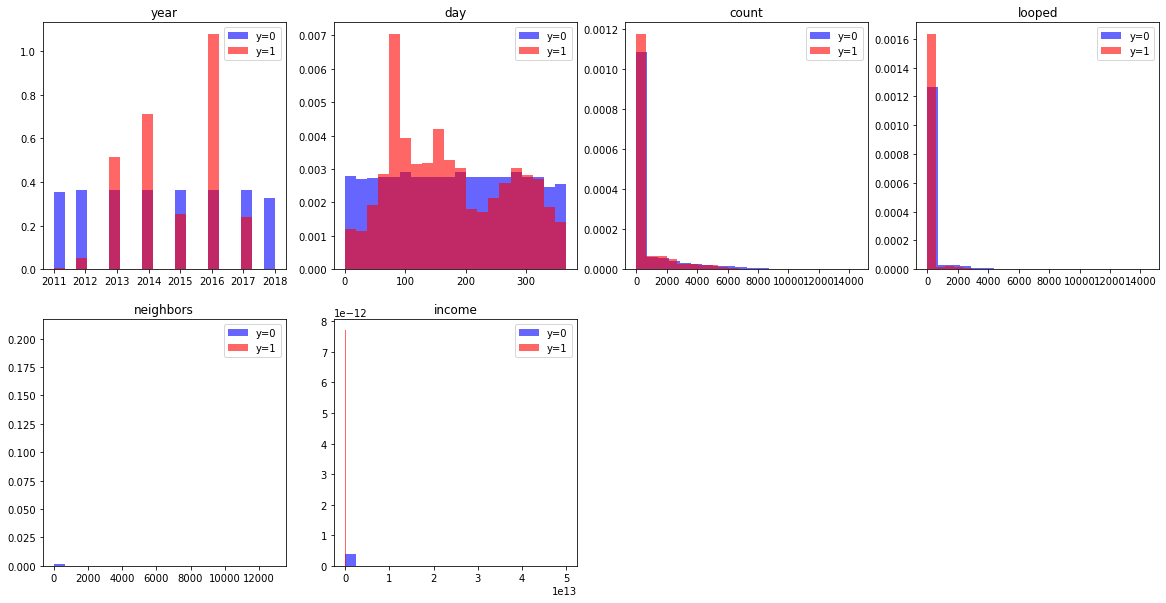

In [ ]:
# Histograma de cada variable separado por clases
plt.figure(figsize=(20,10))

idx_0 =  df['clase'] == 0
idx_1 =  df['clase'] == 1

for i, feature in enumerate(df.columns.drop(['clase'])):
    plt.subplot(2, 4, i+1)   
    plt.hist(df.loc[idx_0,feature],density=1, bins=20, facecolor=(0,0,1,0.6), label='y=0')
    plt.hist(df.loc[idx_1,feature],density=1, bins=20, facecolor=(1,0,0,0.6), label='y=1')
    plt.legend()
    plt.title(feature)
plt.show()

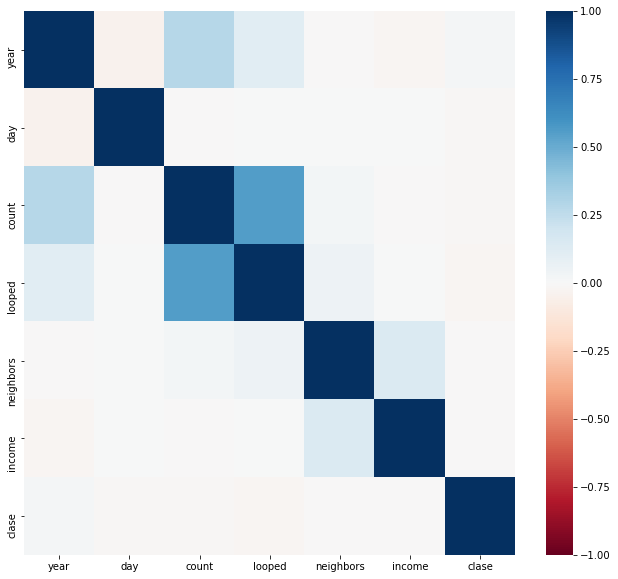

In [ ]:
# Matriz de correlacion
plt.figure(figsize=(11, 10))
sns.heatmap(df.corr(), cmap='RdBu', vmax=1, vmin=-1);

### Preparación de los conjuntos de datos

In [ ]:
# Preparamos los datos
features = df.columns.drop(['clase'])
X = df[features].values
y = df['clase'].values
x_train, x_test, y_train, y_test = train_test_split(X, y, stratify = y, shuffle = True, 
                                                    test_size = 0.2, random_state=seed)
print('Datos train: ', x_train.shape)
print('Datos test:  ', x_test.shape)

print(np.unique(y_train,return_counts=True))
print(np.unique(y_test, return_counts=True))

Datos train:  (1890019, 6)
Datos test:   (472505, 6)
(array([0, 1], dtype=int64), array([1863183,   26836], dtype=int64))
(array([0, 1], dtype=int64), array([465796,   6709], dtype=int64))


In [ ]:
# Balanceamos un poco las clases eliminando registros de la mayoritaria en los datos a usar para el entrenamiento
undersample = RandomUnderSampler(sampling_strategy=0.5, random_state=seed) # con 0.5 estamos diciendo que haya el doble de ejemplos de la clase mayoritaria
x_train, y_train = undersample.fit_resample(x_train, y_train)

print(np.unique(y_train,return_counts=True))

(array([0, 1], dtype=int64), array([53672, 26836], dtype=int64))


### Validación cruzada de hiperparámetros

In [ ]:
Niterations = [25, 50, 75, 100, 150, 200]
learningRate = [0.5, 0.1, 0.05, 0.01]
n_folds = 5
max_depth = 5

param_grid = {'n_estimators': Niterations, 'learning_rate': learningRate}
clf = GradientBoostingClassifier(random_state=seed, max_depth=max_depth)
grid = GridSearchCV(clf, param_grid=param_grid, cv=n_folds)
grid.fit(x_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

best mean cross-validation score: 0.883
best parameters: {'learning_rate': 0.5, 'n_estimators': 150}


### Entrenamiento del modelo

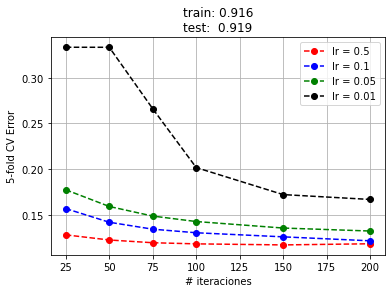

Train:  0.916157400506782
Test:  0.9192643464090328


In [ ]:
bt = GradientBoostingClassifier(random_state=seed, max_depth=max_depth, **grid.best_params_)
bt.fit(x_train, y_train)

error = 1-grid.cv_results_['mean_test_score'].reshape(len(learningRate), len(Niterations))
colors = ['r', 'b', 'g', 'k', 'm']
for i, lr in enumerate(learningRate):    
    plt.plot(Niterations, error[i,:], colors[i] + '--o', label='lr = %g'%lr)

plt.legend()
plt.xlabel('# iteraciones')
plt.ylabel('{}-fold CV Error'.format(n_folds))
plt.title('train: %0.3f\ntest:  %0.3f'%(bt.score(x_train, y_train), bt.score(x_test, y_test)))
plt.grid()
plt.show()

# Obtenemos la precision sobre el train y sobre el test
print("Train: ", bt.score(x_train, y_train))
print("Test: ", bt.score(x_test, y_test))

### Calculamos la importancia de las variables

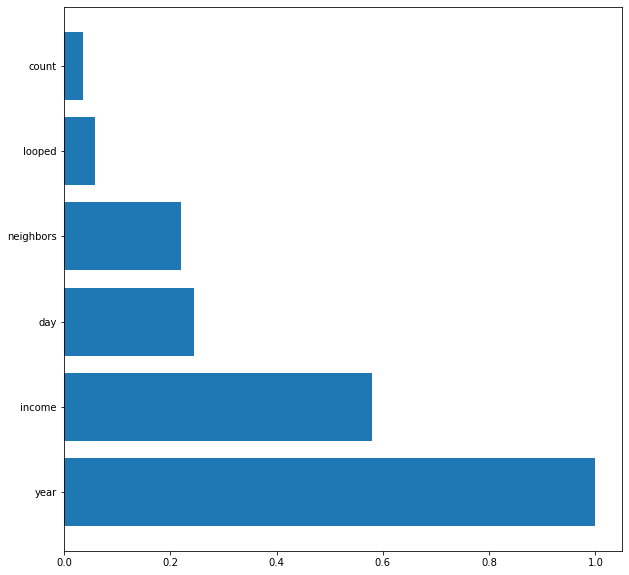

In [ ]:
# Importancia de las variables
importances = bt.feature_importances_
importances = importances / np.max(importances)

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,10))
plt.barh(range(x_train.shape[1]),importances[indices])
plt.yticks(range(x_train.shape[1]),features[indices])
plt.show()

### Matriz de confusión

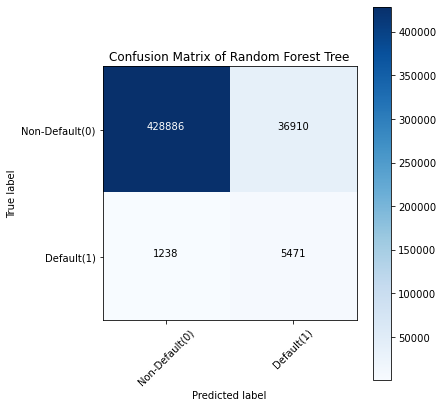

In [ ]:
# Dibujamos la matriz de confusion
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, title, normalize = False, cmap = plt.cm.Blues):
    title = 'Confusion Matrix of {}'.format(title)
    if normalize:
        cm = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment = 'center',
                 color = 'white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


predicciones = bt.predict(x_test)

rf_matrix = confusion_matrix(y_test, predicciones, labels = [0, 1]) 

plt.rcParams['figure.figsize'] = (6, 6)

rf_cm_plot = plot_confusion_matrix(rf_matrix, 
                                classes = ['Non-Default(0)','Default(1)'], 
                                normalize = False, title = 'Random Forest Tree')
plt.show()

### Obtenemos las predicciones sobre el dataset sin label y guardamos los resultados

In [ ]:
predicciones = bt.predict(df_test)
np.savetxt("predicciones_boosted.csv", predicciones, delimiter =",",fmt ='% s')